# NGSIM I-80 freeway data set stats

In [1]:
import pandas as pd
from matplotlib.pylab import *
style.use(['dark_background', 'bmh'])
rc('axes', facecolor='none')

In [2]:
file_name = '/home/boliu/Projects/pytorch-Traffic-Simulator/data_i80/'
file_names = [
    file_name + 'trajectories-0400-0415.txt',
    file_name + 'trajectories-0500-0515.txt',
    file_name + 'trajectories-0515-0530.txt',
]

In [3]:
df = list()
for file_name in file_names:
    df.append(
        pd.read_table(file_name, sep='\s+', header=None, names=(
            'Vehicle ID',
            'Frame ID',
            'Total Frames',
            'Global Time',
            'Local X',
            'Local Y',
            'Global X',
            'Global Y',
            'Vehicle Length',
            'Vehicle Width',
            'Vehicle Class',
            'Vehicle Velocity',
            'Vehicle Acceleration',
            'Lane Identification',
            'Preceding Vehicle',
            'Following Vehicle',
            'Spacing',
            'Headway'
        ))
    )

In [ ]:
# Total number of items
sum([len(d) for d in df])

Things we car to compute:

 - Total number of cars and data points
 - Histogram of neighbouring cars
 - Data set preprocessing
 - Location of recoding and map
 - Total time

In [ ]:
cars = [set(d['Vehicle ID']) for d in df]
nb_of_cars = [len(c) for c in cars]
nb_of_cars, sum(nb_of_cars)

In [ ]:
d = df[0]
int(d[d['Vehicle ID'] == 300]['Frame ID'][:1])

In [ ]:
frames = set(d['Frame ID'])

In [ ]:
print(min(frames), max(frames))

In [ ]:
now = d['Frame ID'] == 1089
df_now = d[now]

In [ ]:
car_now = list(df_now['Vehicle ID'])

In [ ]:
MAX_SPEED = 130  # km / h
FOOT = 0.3048  # metres per foot
delta_x = 130 * 1000 / 3600 / FOOT
delta_y = 2 * 3.7 / FOOT
print(f'dx: {delta_x:.2f}, dy: {delta_y:.2f}')

In [ ]:
i = car_now.index(237)
x = df_now.at[df_now.index[i], 'Local Y'] - df_now.at[df_now.index[i], 'Vehicle Length'] / 2
y = df_now.at[df_now.index[i], 'Local X']
car_id = df_now.at[df_now.index[i], 'Vehicle ID']
print(f'ID: {car_id}, x: {x:.2f}, y: {y:.2f}')

In [ ]:
within_x = df_now['Local Y'].between(x - delta_x, x + delta_x)
within_y = df_now['Local X'].between(y - delta_y, y + delta_y)
neighbours = df_now[within_x & within_y]

In [ ]:
len(neighbours)

In [ ]:
for i in range(len(neighbours)):
    plot(neighbours.at[neighbours.index[i], 'Local X'], neighbours.at[neighbours.index[i], 'Local Y'], 'o')
axis('equal')
axhline(x - delta_x); axhline(x + delta_x)
axvline(y - delta_y); axvline(y + delta_y);

![state](im00025.png)

In [ ]:
from tqdm import tqdm

In [ ]:
d = df[2]
frames = set(d['Frame ID'])
cars_per_frame = list()
neighbouring_cars = list()
for frame in tqdm(frames):
# frame = 1089
    now = d['Frame ID'] == frame
    df_now = d[now]
    cars_per_frame.append(len(df_now))
    for i in range(len(df_now)):
        x = df_now.at[df_now.index[i], 'Local Y'] - df_now.at[df_now.index[i], 'Vehicle Length'] / 2
        y = df_now.at[df_now.index[i], 'Local X']
        within_x = df_now['Local Y'].between(x - delta_x, x + delta_x)
        within_y = df_now['Local X'].between(y - delta_y, y + delta_y)
        neighbours = df_now[within_x & within_y]
        neighbouring_cars.append(len(neighbours))

In [ ]:
len(cars_per_frame), len(neighbouring_cars)

In [ ]:
len(cars_per_frame), len(neighbouring_cars)

In [ ]:
len(cars_per_frame), len(neighbouring_cars)

In [ ]:
cars_per_frame[5000:5010]

In [ ]:
neighbouring_cars[600000:600010]

In [ ]:
data_set_stats = {
    16001615: {
        'cars_per_frame': array(cars_per_frame, dtype=uint16),
        'neighbouring_cars': array(neighbouring_cars, dtype=uint16)
    }
}

In [ ]:
data_set_stats[17001715] = {
    'cars_per_frame': array(cars_per_frame, dtype=uint16),
    'neighbouring_cars': array(neighbouring_cars, dtype=uint16)
}

In [ ]:
data_set_stats[17151730] = {
    'cars_per_frame': array(cars_per_frame, dtype=uint16),
    'neighbouring_cars': array(neighbouring_cars, dtype=uint16)
}

In [ ]:
# save('data_set_stats', data_set_stats)
data_set_stats = load('data_set_stats.npy').item()

In [ ]:
tuple(data_set_stats.keys())

In [ ]:
for a, b in data_set_stats.items():
    print(f'time: {a}', *[f"{c[0]}: {len(c[1])}" for c in b.items()], sep=', ')

In [ ]:
figure(figsize=(16,8))
f = 1
for a, b in data_set_stats.items():
    subplot(2, 3, f)
    hist(b['neighbouring_cars'], 100)
    title(a)
    xlabel('Number of neighbouring cars')
    
    subplot(2, 3, f + 3); f += 1
    hist(b['cars_per_frame'], 100)
    title(a)
    xlabel('Number of cars per frame')
    
tight_layout()

In [ ]:
frame = df[2]['Frame ID']
min(frame), max(frame)

In [ ]:
df2 = df[2]

In [4]:
def check_collision(v, f, d):
    
    v1, v2 = v
    f1, f2, f3 = f
    
    f1 = f3 - 30 if f1 is None else f1
    f2 = f3 + 30 if f2 is None else f2

    frames = df[d][(df[d]['Vehicle ID'] == v1) & df[d]['Frame ID'].between(f1, f2)]['Frame ID'].values
    dfv1 = df[d][(df[d]['Vehicle ID'] == v1) & df[d]['Frame ID'].between(f1, f2)]
    dfv2 = df[d][(df[d]['Vehicle ID'] == v2) & df[d]['Frame ID'].between(f1, f2)]

    plt.figure(figsize=(18,6))
    plt.axhline(ls='--')
    plt.axvline(f3, ls='--')
    plt.plot(frames, (dfv1['Local Y'].values - dfv2['Local Y'].values) * foot, label='x diff')
    plt.plot(frames, -(dfv1['Local X'].values - dfv2['Local X'].values) * foot, label='y diff')

    # plt.axis((f1, f2, -.2, 3))
    plt.ylabel('inter-distance [m]')
    plt.xlabel('frame index [ / ]')
    plt.legend()
    plt.title(f'Collision of vehicle {v1} and {v2}')

    plt.axhline((dfv1['Vehicle Width'].iloc[0] + dfv2['Vehicle Width'].iloc[0]) * foot / 2, color='C1', ls='--')
    plt.axhline(-(dfv1['Vehicle Width'].iloc[0] + dfv2['Vehicle Width'].iloc[0]) * foot / 2, color='C1', ls='--')
    plt.axhline(dfv1['Vehicle Length'].iloc[0] * foot, color='C0', ls='--')
    plt.text(f1, dfv1['Vehicle Length'].iloc[0] * foot + .3, f'vehicle {v1} length', color='C0')
    plt.axhline(-dfv2['Vehicle Length'].iloc[0] * foot, color='C0', ls='--')
    plt.text(f1, -dfv2['Vehicle Length'].iloc[0] * foot + .3, f'vehicle {v2} length', color='C0')


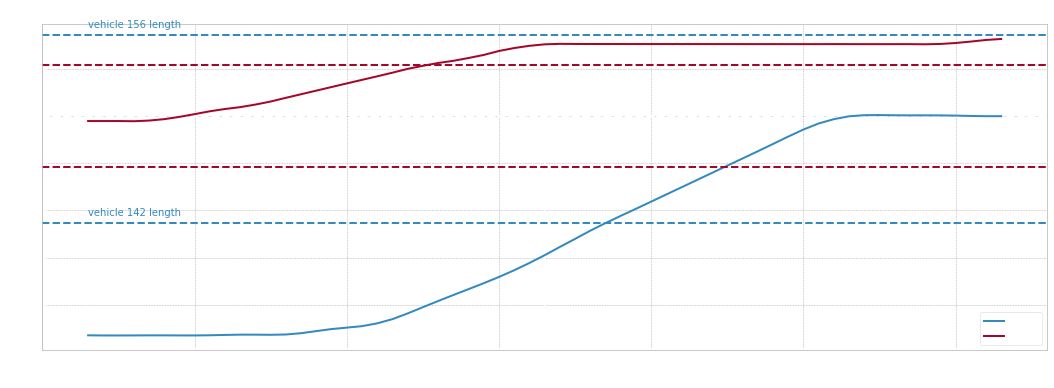

In [8]:
d = 2

# bug = 1635,269,295  # GTB
bug = 1733,156,142  # max_dy
# bug = 1893,3004,246  # GTB
# bug = 2235,338,327  # max_dy
# bug = 2681,493,510  # wiggly
# bug = 2742,567,549  # GTB
# bug = 3016,680,684  # max_dy
# bug = 3265,769,722  # GTB
# bug = 3498,790,811  # GTB (see above)
# bug = 3633,797,815  # wiggly
# bug = 3731,862,847  # max_dy
# bug = 3875,870,860  # GTB
# bug = 4465,1068,1084  # max_dy
# bug = 4690,1163,1157  # max_dy
# bug = 4878,1163,1153  # GTB / motor width
# bug = 5166,1329,1322  # max_dy
# bug = 5760,1552,1519  # max_dy + GTB?
# bug = 6269,1603,1596  # GTB
# bug = 6280,1651,1654  # GTB WTF
# bug = 6365,1734,1748  # GTB WTF 2 (see above)
# bug = 6628,1762,1767  # GTB
# bug = 6684,1734,1742  # GTB WTF 3
# bug = 6709,1800,1788  # GTB (see above)
# bug = 6720,1727,1722  # GTB WTF 4 (see above)
# bug = 7472,1926,1921  # GTB
# bug = 7553,1868,1878  # GTB
# bug = 8263,2061,2056  # GTB WTF 5
# bug = 8345,2075,2141  # GTB
# bug = 8449,2282,2258  # GTB WTF 6 (see above)
# bug = 8568,2080,2122  # GTB
# bug = 8757,2239,2252  # GTB
# bug = 8910,2252,2239  # GTB
# bug = 8952,2274,2285  # GTB WTF 7 (see next)
# bug = 8979,2264,2285  # GTB WTF 7 cont.
# bug = 9010,2263,2285  # GTB WTF 7 cont.
# bug = 9056,2263,2285  # GTB WTF 7 cont.
# bug = 9140,2264,2285  # GTB WTF 7 cont.
# bug = 9180,2274,2285  # GTB WTF 7 cont.
# bug = 9430,2370,2362  # GTB
# bug = 9631,2369,2392  # max_dy
# bug = 10035,2480,2468  # max_dy

# d = 0

# bug = 778,174,163  # wiggly
# bug = 781,169,174  # max_dy
# bug = 1033,189,186  # max_dy
# bug = 1265,268,264  # max_dy + GTB?
# bug = 1479,393,365  # max_dy
# bug = 1533,394,406  # max_dy (very limiting)
# bug = 1823,493,518  # max_dy
# bug = 4800,1589,1606  # GTB
# bug = 5083,1628,1629  # GTB
# bug = 6459,2102,2089  # GTB WTF
# bug = 6620,2143,2144  # GTB WTF
# bug = 7157,3365,2326

foot = 0.3048  # m
check_collision(bug[1:], (None, None, bug[0]), d)

In [ ]:
d = 2

v =  790, 811; f = 3490, 3550, 3498
v = 1734, 1748; f = 6070, 6682, 6300  # GTB WTF 2
v = 1800, 1788; f = 6700,6820,6708
v = 1727, 1722; f = 6710, 6800, 6720  # GTB WTF 4
# v = 2258, 2282; f = 8350, 8530, 8400

check_collision(v, f, d)

# Traffic-Simulator

Can you type anything? Aweomse!

# Versions of `traffic_gym`

* `v0`: rule-based traffic (ego car is just one of the cars)
* `v1`: I-80 human drivers, I-80 map
* `v2`: rules-based or imitation vehicles on I-80 map
* `v3`: controlled ego car on I-80 map
    * `v3` is the only one which is currently supporting an external policy

**Bo**: for `v2`, why it is called `PatchedCar` and `MergingMap`?
**Alf**: So, rules-based vehicles move online on horizontal lines. Here, I'm patching the `Car` class so that, if it's on the merging ramp, then I'm constantly updating `self._target_lane`, so that to give the impression is follows a slanted line. The PID controller simply follows a target, which is constantly changing, rather than been fixed on a specific lane.
**Bo**: 
* sounds like a `LaneChangeCar` ?
* So, it is not just Merging, but also Lane Change?

**Alf**: hold on, what are you talking about?
**Bo**: naming of the classes.

`class Car` does move horizontally, brake, speed up, pass to the left or to the right, if safe.
`class PatchedCar(Car)` does all `Car` does, but if we happen to be on the ramp, then our `self._target_lane` keeps changing (this is a hack / patch, not the proper way of handling this). In this way I have cars moving on a slanted lane.

**Bo**: in this case, we don't need a subclass of `PatchedCar`. Just use `Car` but updating the `_targe_lane` property.
**Alf**: this would break `v0`. `v0` can simulate any number of lanes, and all cars have the prescribed behaviour. `PatchedCar` knows there are only `7` lanes, and the `7`-th is the ramp.

**Alf**: `v0` is generic. That was the initial environment. I believe the whole simulator should be rewritten, but for the purpose we need it (doing research), it is overkilling. We add and remove stuff daily... Subclassing the the less painfull approach.

**Bo**: Let's keep those notes and don't worry about refactoring just for now. The naming part of the code base will need a clean up otherwise the engineering perspective might blow up sooner or later.

**Alf**: our priority, for the moment, is to remove the most obvious collisions due to ground truth bugs, GTB, and to the poor kinematic modelling and noise in the measurements (unicycle model + Kalman).

**Bo**: for the kinematic modelling. I am going to add an internal representation of the state vector (CTRV augmented state vector) for the `Car` class and add a function (we call it `update_state(self, action, observation)`) to update the state vector using an observation as input. We will need another getter function to access the state vector (we call it something like `get_state(self)` which returns the state vector).

 * in this `update_state()`, a UKF, a CTRV motion model and an observation model will handle the state estimate.

**Bo**: what is the format of an observation? an observation basically means a sensor fetch: a gps location, an IMU reading (acceleration, heading) etc. 

**Alf**: so, there are two observations. A deprecated symbolic one [here](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/master/traffic_gym.py#L138) and an image based [here](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/master/traffic_gym.py#L407).

**Bo**: can we extract the location of the car from an observation?

**Alf**: sure, and observation now has position, velocity, and context image state (neighbouring occupancy grid).

**Bo**: Good! we need position, speed, speed-direction for the CTRV model.

**Alf**: All this stuff is already available in `Car`. If you check, you have:

```python=
self._length = round(4.8 * self.SCALE)
self._width = round(1.8 * self.SCALE)
self.id = car_id
lane = random.choice(tuple(free_lanes))
if lane == 6 and type(self).__name__ == 'PatchedCar':
    self._position = np.array((0, lanes[-1]['max'] + 42), np.float)
    self._direction = np.array((1, -0.035), np.float) / np.sqrt(1 + 0.035 ** 2)
else:
    self._position = np.array((
        -self._length,
        lanes[lane]['mid']
    ), np.float)
    self._direction = np.array((1, 0), np.float)
self._target_speed = max(
    0,
    (MAX_SPEED - random.randrange(0, 15) - 10 * lane)
) * 1000 / 3600 * self.SCALE  # m / s
self._speed = self._target_speed
self._dt = dt
self._colour = colours['c']
self._braked = False
self._passing = False
self._target_lane = self._position[1]
self._noisy_target_lane = self._target_lane
self.crashed = False
self._error = 0
self._states = list()
self._states_image = list()
self._actions = list()
self._safe_factor = random.gauss(1.5, 0)  # 0.9 Germany, 2 safe
self.pid_k1 = np.random.normal(1e-4, 1e-5)
self.pid_k2 = np.random.normal(1e-3, 1e-4)
self.look_ahead = look_ahead
self.screen_w = screen_w
self._text = self.get_text(self.id, font)
self._policy_type = policy_type
self.policy_network = policy_network
self.is_controlled = False
self.collisions_per_frame = 0
```

What we care, usually is `self._length`, `self._width`, `self.id`, `self._speed`, `self._direction`, `self._position`.

**Bo**: this is good enough. Let me work on it a little bit then I will get back to pushing the code to git repo.

What are our plans before next meeting? Fixing those fuckers then meet and discuss what? 

**Alf**: so, this week, on the engineering part, we need

 1. no collisions
     * ground truth bugs (Alf)
     * wigglying (Bo)
     * max delta-y limitation removal (Bo)
 2. pixel based proximity cost (Alf)
     * which will enable any map geometry to be used

**Bo**: sure, clear enough! Let's get back to work.

**Alf**: sweet! So, in short, it's just the unicycle kinematic model and the Kalman filter, right?

**Bo**: yes, augmented unicycle model (unicycle w/o allowing spinning) and UKF.

**Alf**: You should be able to use the debugging branch for playing with the kinematic model, and check that those wigglying busses and limited $\partial y$ vehicles are now working fine.

**Bo**: yes, I created a new branch based on the debugging branch just to keep the sanity.

**Alf**: You can use that branch. I created it for you.

**Bo**: OK! If you need to modify that branch, let me know.

**Alf**: I won't. That was "a branch for Bo, so that he can debug".

**Bo**: got it. That is it for today? 

**Alf**: So, that *is* a debugging branch. So, it won't be merged, ever. I have to point out that vehicles here are simply following the trajectories. In the real case we extract the action $a, b$ (acceleration, and tangetial deviation) by inverting the kinematic model, and then use these to run the vehicle, by applying them (again) to the kinematic model. Does it make any sense???

**Bo**: Yes, so this is basically a tracking case (w/o actuation control)? 

**Alf**: debugging == tracking. We need actions in order to train the predictive model. So we **do** need to invert the kinematic model in order to extract $a, b$.
 
**Bo**: OK, it is easy to do. Action can be expressed directly by $a, b$.
Basically we use $a, b$ directly in the state transition matrix. $a, b$ are computed from data.

**Alf**: ah, that I don't know. I'm not super familiar. Are they? That would be great. So, let me put here a few locations in the code you need to pay attention to.

 * [Collision branch](https://github.com/Atcold/pytorch-Traffic-Simulator/tree/collisions)
 * [step v1](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym_v1.py#L80-L87) is usually commented, and [step v0](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym.py#L244-L263) is used instead
 * Therefore, [step v0](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym.py#L244-L263) will require the modified unicycle kinematic model
 * [filtering and gradient clipping](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym_v1.py#L33-L39) should be unnecessary when proper kinematic model is used instead
    * probably yes, it depends on the noise of data. The data could be far off, in this case we might need clipping. However, if the covariance matrix is estimated well enough by the KF library, clipping is not needed; the update step should ignore "noise spikes" according to Kalman gain.
 * [`_get()`](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym_v1.py#L70-L77) should get the right stuff, especially with respect to the current position, and not just trajectory relative information
 * [v1 policy()](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym_v1.py#L89-L102) returns $a, b$ from the data
 * [v0 step()](https://github.com/Atcold/pytorch-Traffic-Simulator/blob/collisions/traffic_gym.py#L244-L263) should step according `v1 policy()`'s $a, b$.

**Alf**: and this should be all. If you have any question, please, feel free to bug me. Also, you won't be able to merge the `collisions` branch. We'll have to cherry-pick your commit onto `master`.

**Bo**: Sure! 